# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/home/dongjp/source-code/PyEEG


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_path_to_genotype', 'parse_path_to_animal', 'parse_path_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
core.set_temp_directory('/scr1/users/dongjp')

In [4]:
tmpmet = core.DDFBinaryMetadata(r"/mnt/isilon/marsh_single_unit/PythonEEG Data Bins/A5 WT 12_12-2023/Cage 1 A5 -1_Meta.csv")
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Tue Dec 12 12:57:00 2023


['Intan Input (1)/PortB L Aud Ctx',
 'Intan Input (1)/PortB L Vis Ctx',
 'Intan Input (1)/PortB L Hipp',
 'Intan Input (1)/PortB L Barrel',
 'Intan Input (1)/PortB L Motor',
 'Intan Input (1)/PortB R Motor',
 'Intan Input (1)/PortB R Barrel',
 'Intan Input (1)/PortB R Hipp',
 'Intan Input (1)/PortB R Vis Ctx',
 'Intan Input (1)/PortB R Aud Ctx']

In [5]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/home/dongjp/source-code/PyEEG/pythoneeg/core/core.py:152: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [6]:
Path('./test-wars/A5').resolve()

PosixPath('/home/dongjp/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [7]:
# cluster_window = SLURMCluster(
#         cores=8,
#         processes=1, # Threaded parallelization works best for WAR
#         memory='20GB',
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_window.scale(jobs=15)
# display(cluster_window)
# cluster_window.wait_for_workers(15)

In [8]:
# cluster_spike = SLURMCluster(
#         cores=1,
#         memory='10GB',
#         processes=1,
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_spike.scale(12)
# display(cluster_spike)
# cluster_spike.wait_for_workers(12)

In [9]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5']
# animal_ids = ['A10', 'F22']
animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=3)
    ao.convert_colbins_to_rowbins(overwrite=False)
    # ao.convert_rowbins_to_rec() # parallelization breaks if not enough memory

    with Client(LocalCluster()) as client:
        client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running war")
        ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
        war = ao.compute_windowed_analysis(['all'], multiprocess_mode='dask')
        # war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    with Client(LocalCluster()) as client:
        client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running sars")
        sars = ao.compute_spike_analysis(multiprocess_mode='dask')
    raws = []
    for sar in sars:
        raws.append(sar.convert_to_mne())

    war.read_mnes_spikes(raws)

/home/dongjp/source-code/PyEEG/pythoneeg/core/core.py:152: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
Converting column bins to row bins: 100%|██████████| 1/1 [00:00<00:00, 55.38it/s]

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 5.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38249,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 5.78 GiB
Comm: tcp://127.0.0.1:34553,Total threads: 1
Dashboard: http://127.0.0.1:41657/status,Memory: 1.45 GiB
Nanny: tcp://127.0.0.1:35623,


running war


Converting row bins to recs: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-014', 'Intan Input (1)/PortD D-015', 'Intan Input (1)/PortD D-016', 'Intan Input (1)/PortD D-017', 'Intan Input (1)/PortD D-019', 'Intan Input (1)/PortD D-021', 'Intan Input (1)/PortD D-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41753 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41753/status,
Dashboard: http://127.0.0.1:41753/status,Workers: 4
Total threads: 4,Total memory: 5.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40817,Workers: 4
Dashboard: http://127.0.0.1:41753/status,Total threads: 4
Started: Just now,Total memory: 5.78 GiB
Comm: tcp://127.0.0.1:43113,Total threads: 1
Dashboard: http://127.0.0.1:36003/status,Memory: 1.45 GiB
Nanny: tcp://127.0.0.1:46527,


running sars


write_binary_recording (no parallelization): 100%|██████████| 8/8 [00:00<00:00, 21.40it/s]
/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:586: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:586: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:586: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:586: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


Creating RawArray with float64 data, n_channels=10, n_times=466440
    Range : 0 ... 466439 =      0.000 ...   466.439 secs
Ready.
Used Annotations descriptions: [np.str_('Intan Input (1)/PortD D-009'), np.str_('Intan Input (1)/PortD D-010'), np.str_('Intan Input (1)/PortD D-012'), np.str_('Intan Input (1)/PortD D-014'), np.str_('Intan Input (1)/PortD D-015'), np.str_('Intan Input (1)/PortD D-016'), np.str_('Intan Input (1)/PortD D-017'), np.str_('Intan Input (1)/PortD D-019')]


In [10]:
df_test = war.result.drop(columns=constants.MATRIX_FEATURE)

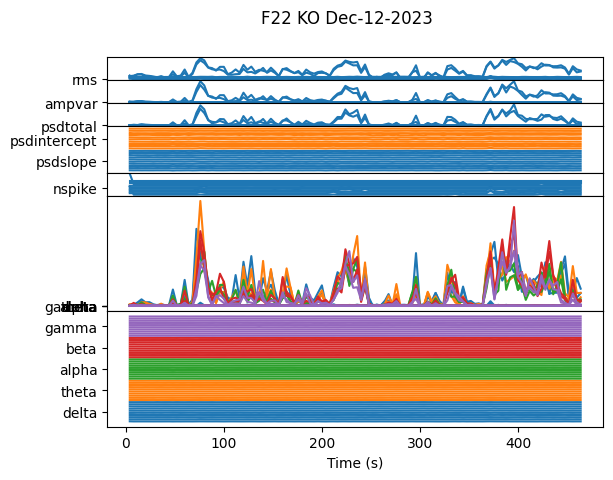

In [11]:
ap = visualization.AnimalPlotter(war)
ap.plot_linear_temporal(score_type=None)

## Test WAR

In [12]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [13]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/F22').resolve())

2025-04-08 20:54:12,223 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:12,226 - WARNING - Intan Input (1)/PortD D-010 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:12,226 - WARNING - Intan Input (1)/PortD D-012 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:12,227 - WARNING - Intan Input (1)/PortD D-014 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:12,229 - WARNING - Intan Input (1)/PortD D-015 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:12,229 - WARNING - Intan Input (1)/PortD D-016 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:12,230 - WARNING - Intan Input (1)/PortD D-017 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:12,231 - WARNING - Intan

In [14]:
war.get_result(['all'], allow_missing=True).head(3)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdfrac,psdslope,cohere,pcorr,nspike
0,0,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:13.560,True,"[324.54126, 123.114975, 89.73853, 199.99457, 3...","[98233.31, 14860.118, 7970.6294, 37275.664, 15...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2991.1634385554166, 9655.58377513804, 4896.79...","{'delta': [2371.695324738739, 3296.14610609939...","{'delta': [0.7929006132423677, 0.3413720167377...","[[-1.6266363283601732, 3.0386960730587895], [-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN
1,1,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:17.560,True,"[33.98209, 98.85394, 73.50655, 72.370285, 407....","[1154.7565, 9768.589, 5399.9756, 5234.582, 165...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[617.6503225177026, 8764.378583594078, 4536.85...","{'delta': [190.0428130962193, 1800.43295303487...","{'delta': [0.3076867382203503, 0.2054261960346...","[[-1.2730235496671296, 2.4032617509449405], [-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN
2,2,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:21.560,True,"[39.47056, 100.14916, 70.84106, 86.55565, 620....","[1557.7701, 10023.703, 5018.388, 7481.0225, 38...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[808.7404621241202, 7759.685803861311, 3899.87...","{'delta': [306.9726448654066, 2821.06366983401...","{'delta': [0.3795687977069391, 0.3635538527127...","[[-1.4760446379997991, 2.664199600531952], [-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN


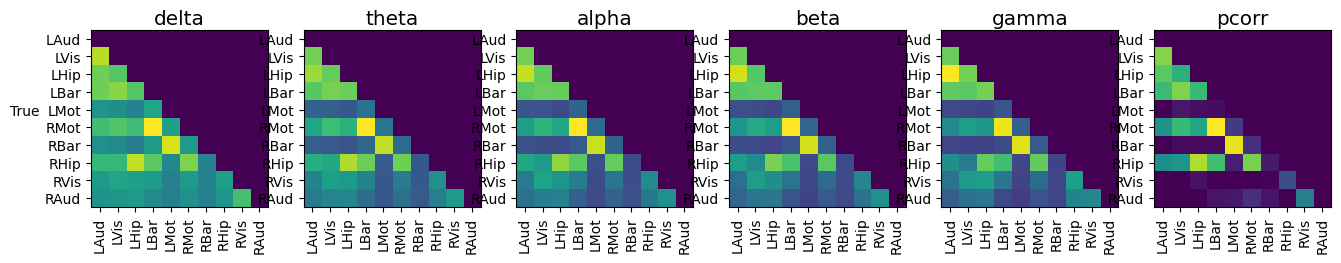

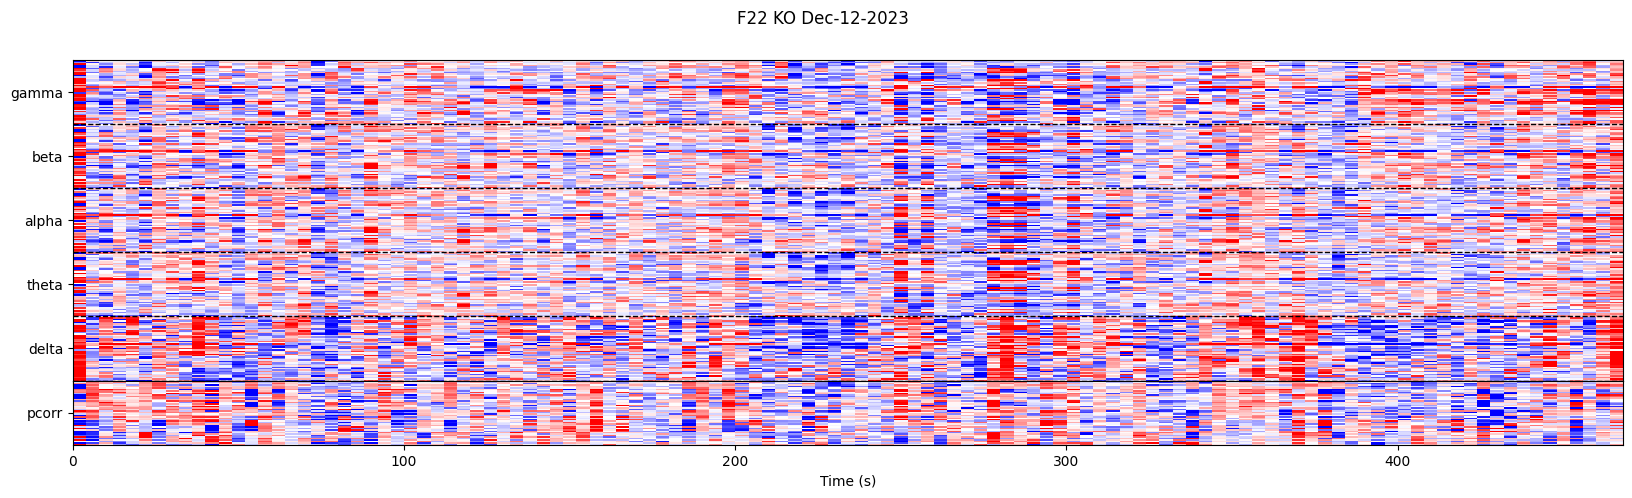

/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/animal.py:317: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


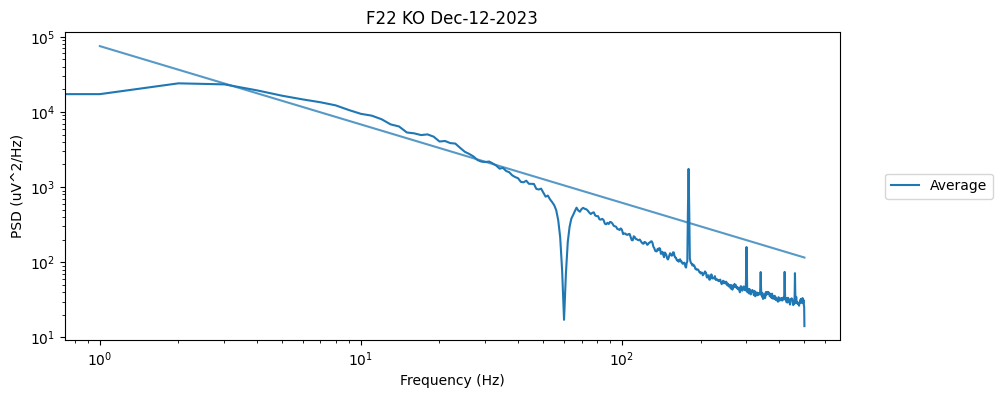

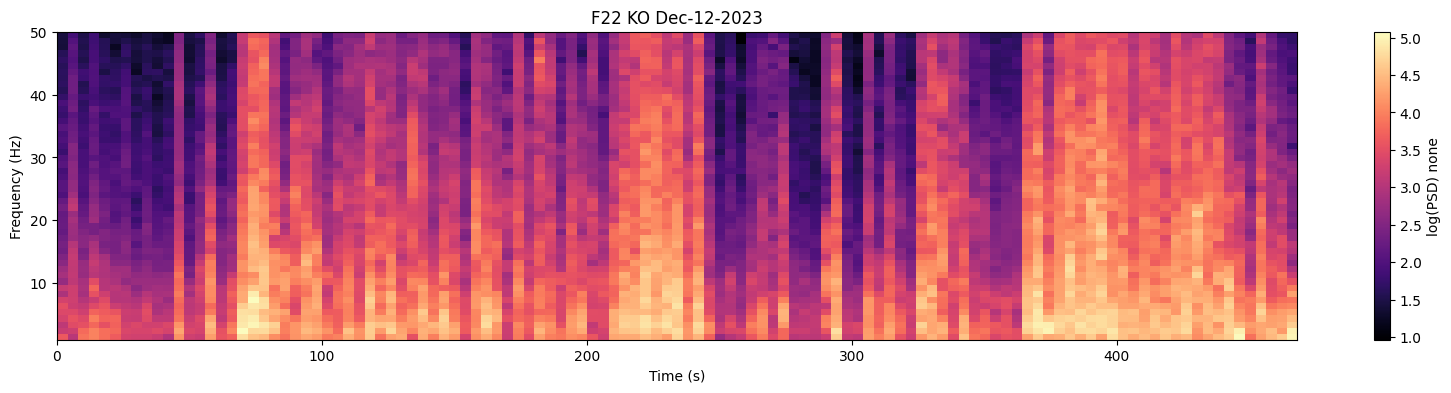

In [15]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [16]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    # REVIEW consider making this process a single one-line function
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    war = war.filter_all()
    wars.append(war)

    sars = []
    for path in Path('./test-sars/').glob(f'*{animal_id}*'):
        sars.append(visualization.SpikeAnalysisResult.load_fif_and_json(path))
    war.read_sars_spikes(sars, read_mode='mne')

ep = visualization.ExperimentPlotter(wars)


2025-04-08 20:54:14,510 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,514 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,515 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,516 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,518 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,519 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,521 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,523 - WARNING - Intan

2025-04-08 20:54:14,541 - INFO - Filtering psd
2025-04-08 20:54:14,545 - INFO - Filtering psdtotal
2025-04-08 20:54:14,547 - INFO - Filtering psdband
2025-04-08 20:54:14,551 - INFO - Filtering psdfrac
2025-04-08 20:54:14,561 - INFO - Filtering psdslope
2025-04-08 20:54:14,570 - INFO - Filtering cohere
2025-04-08 20:54:14,582 - INFO - Filtering pcorr
2025-04-08 20:54:14,584 - INFO - Skipping nspike because it is not in result
2025-04-08 20:54:14,586 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,586 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,589 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,590 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:14,591

In [17]:
for feat in constants.LINEAR_FEATURE:
    logging.info(f'pulling {feat}')
    ep.pull_timeseries_dataframe(feat, ['genotype','animalday'])

df2 = ep.pull_timeseries_dataframe('rms', ['genotype','animal'], collapse_channels=True)

2025-04-08 20:54:14,949 - INFO - pulling rms
2025-04-08 20:54:14,960 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-04-08 20:54:14,963 - DEBUG - vals.shape: (31, 10)
2025-04-08 20:54:14,968 - DEBUG - vals.shape: (117, 10)
2025-04-08 20:54:14,982 - INFO - pulling ampvar
2025-04-08 20:54:14,994 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-04-08 20:54:14,996 - DEBUG - vals.shape: (31, 10)
2025-04-08 20:54:14,999 - DEBUG - vals.shape: (117, 10)
2025-04-08 20:54:15,006 - INFO - pulling psdtotal
2025-04-08 20:54:15,009 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-04-08 20:54:15,010 - DEBUG - vals.shape: (31, 10)
2025-04-08 20:54:15,012 - DEBUG - vals.shape: (117, 10)
2025-04-08 20:54:15,024 - INFO - pulling psdslope
2025-04-08 20:54:15,031 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-04-08 20:54:15,032 - DEBUG - vals.shape: (31, 10, 2)
2025

/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:140: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:140: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


In [18]:
logger.setLevel(logging.DEBUG)
wars_bad = []
# animal_ids = ['A10', 'F22']
animal_ids = ['A10']
for animal_id in animal_ids:
    # war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    war_bad = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    wars_bad.append(war_bad)
try:
    ep_bad = visualization.ExperimentPlotter(wars_bad)
    ep_bad.pull_timeseries_dataframe('nspike', ['animal'], collapse_channels=False)
except KeyError as e:
    logging.error(e)

2025-04-08 20:54:15,134 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:15,135 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:15,136 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:15,138 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:15,140 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:15,140 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:15,141 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-04-08 20:54:15,147 - WARNING - Intan

2025-04-08 20:54:15,151 - WARNING - Intan Input (1)/PortC C-022 does not match name aliases. Assuming alias from number in channel name.
Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
2025-04-08 20:54:15,155 - INFO - channel_names: [['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']]
2025-04-08 20:54:15,159 - INFO - channel_to_idx: [{'LAud': 0, 'LVis': 1, 'LHip': 2, 'LBar': 3, 'LMot': 4, 'RMot': 5, 'RBar': 6, 'RHip': 7, 'RVis': 8, 'RAud': 9}]
2025-04-08 20:54:15,160 - INFO - all_channel_names: ['LAud', 'LBar', 'LHip', 'LMot', 'LVis', 'RAud', 'RBar', 'RHip', 'RMot', 'RVis']
2025-

2025-04-08 20:54:15,182 - DEBUG - groups: ['A10', 'F22']
2025-04-08 20:54:15,183 - DEBUG - vals.shape: (31, 10)
2025-04-08 20:54:15,189 - DEBUG - vals.shape: (117, 10)


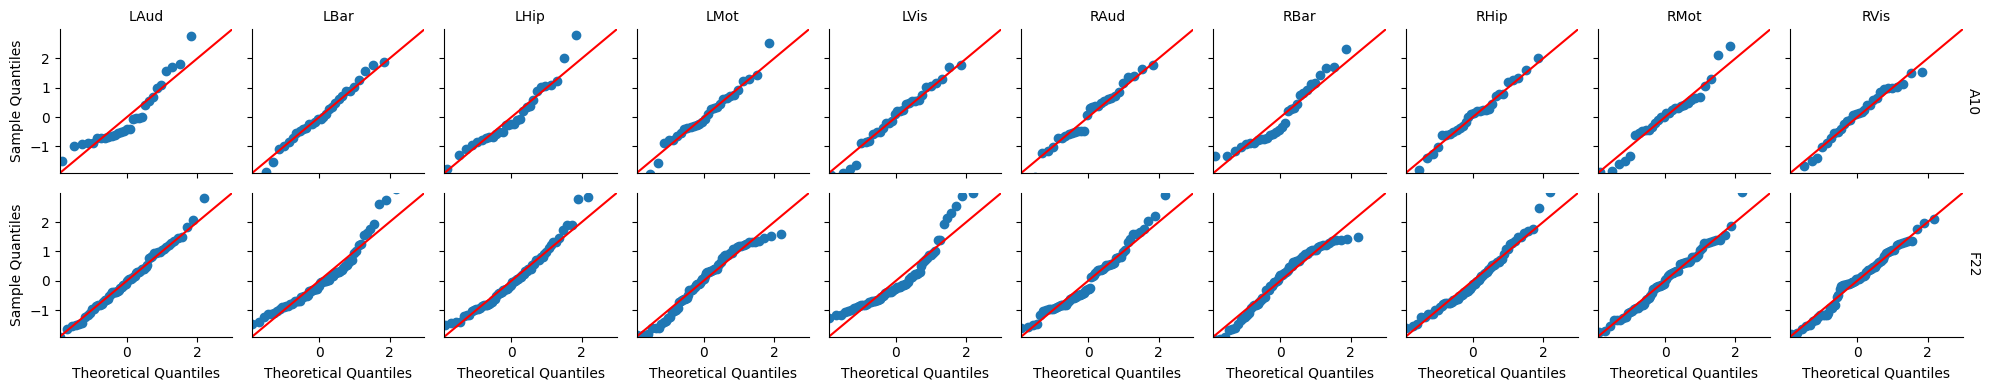

In [19]:
# g = ep.plot_qqplot('psdband', ['animal'], row='channel', col='band', height=2, log=True)
# plt.show()
g = ep.plot_qqplot('rms', ['animal'], row='animal', col='channel', height=2, log=True)
plt.show()
# g = ep.plot_qqplot('psdband', ['animal'], row='animal', col='channel', height=3, log=True)
# plt.show()

2025-04-08 20:54:18,584 - DEBUG - groups: ['A10', 'F22']
2025-04-08 20:54:18,585 - DEBUG - vals.shape: (31, 10, 5)
2025-04-08 20:54:18,589 - DEBUG - vals.shape: (117, 10, 5)
2025-04-08 20:54:20,703 - DEBUG - pairs: [(('A10', 'LAud'), ('F22', 'LAud')), (('A10', 'LBar'), ('F22', 'LBar')), (('A10', 'LHip'), ('F22', 'LHip')), (('A10', 'LMot'), ('F22', 'LMot')), (('A10', 'LVis'), ('F22', 'LVis')), (('A10', 'RAud'), ('F22', 'RAud')), (('A10', 'RBar'), ('F22', 'RBar')), (('A10', 'RHip'), ('F22', 'RHip')), (('A10', 'RMot'), ('F22', 'RMot')), (('A10', 'RVis'), ('F22', 'RVis'))]
2025-04-08 20:54:20,772 - DEBUG - rectangle width is larger than the typical group artist: 2.0
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A10_RVis vs. F22_RVis: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-13 U_stat=1.458e+04
A10_LAud vs. F22_LAud: Mann-Whitney-Wilcoxo

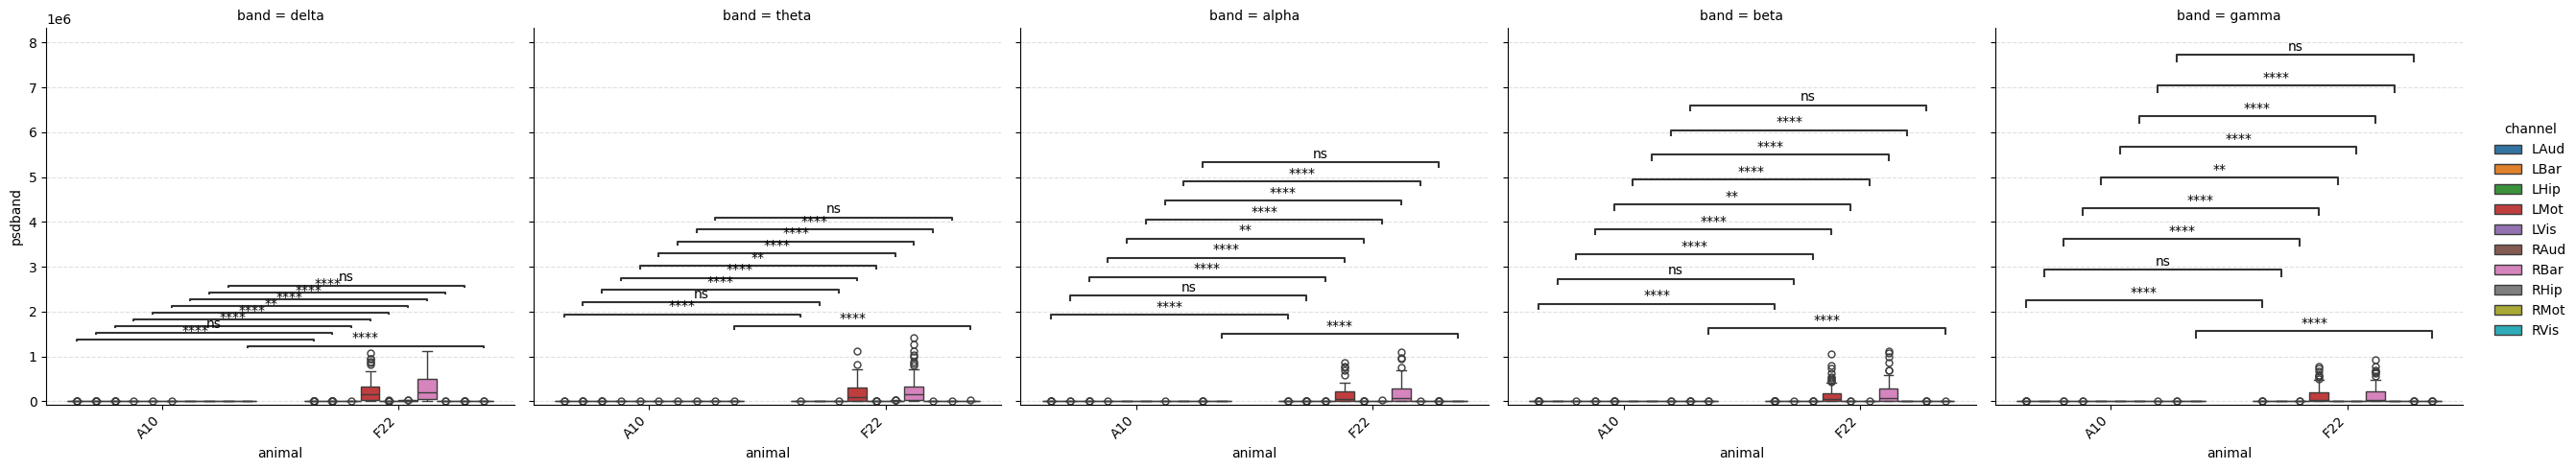

In [20]:
g = ep.plot_catplot('psdband', ['animal'], 
                    collapse_channels=False, hue='channel', col='band',
                    stat_pairs='x',
                    # stat_pairs=[[('A10 KO Dec-13-2023', 'theta'), ('F22 KO Dec-12-2023', 'delta')]],
                    # stat_pairs=[[('F22', 'delta'), ('F22', 'theta')], [('F22', 'theta'), ('A10', 'theta')]], 
                    # stat_pairs=[[('F22', 'delta'), ('F22', 'theta')], [('F22', 'theta'), ('A10', 'theta')]], 
                    # stat_pairs=perms,
                    # stat_test='Brunner-Munzel',
                    # norm_test='log-D-Agostino',
                    )

In [ ]:
# Read in A10 WAR from test-wars-full
war_a10 = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars-full/A10').resolve())

# Create ExperimentPlotter
ep = visualization.ExperimentPlotter([war_a10])

# Plot boxplot
# ep.plot_catplot('nspike', groupby='isday', kind='violin')
df_cat = ep.pull_timeseries_dataframe('nspike', ['animalday'])

## Test SAR/MNE

2025-04-08 15:00:29,946 - DEBUG - groups: ['A10', 'F22']
2025-04-08 15:00:29,948 - DEBUG - vals.shape: (31, 10, 5)
2025-04-08 15:00:29,954 - DEBUG - vals.shape: (117, 10, 5)


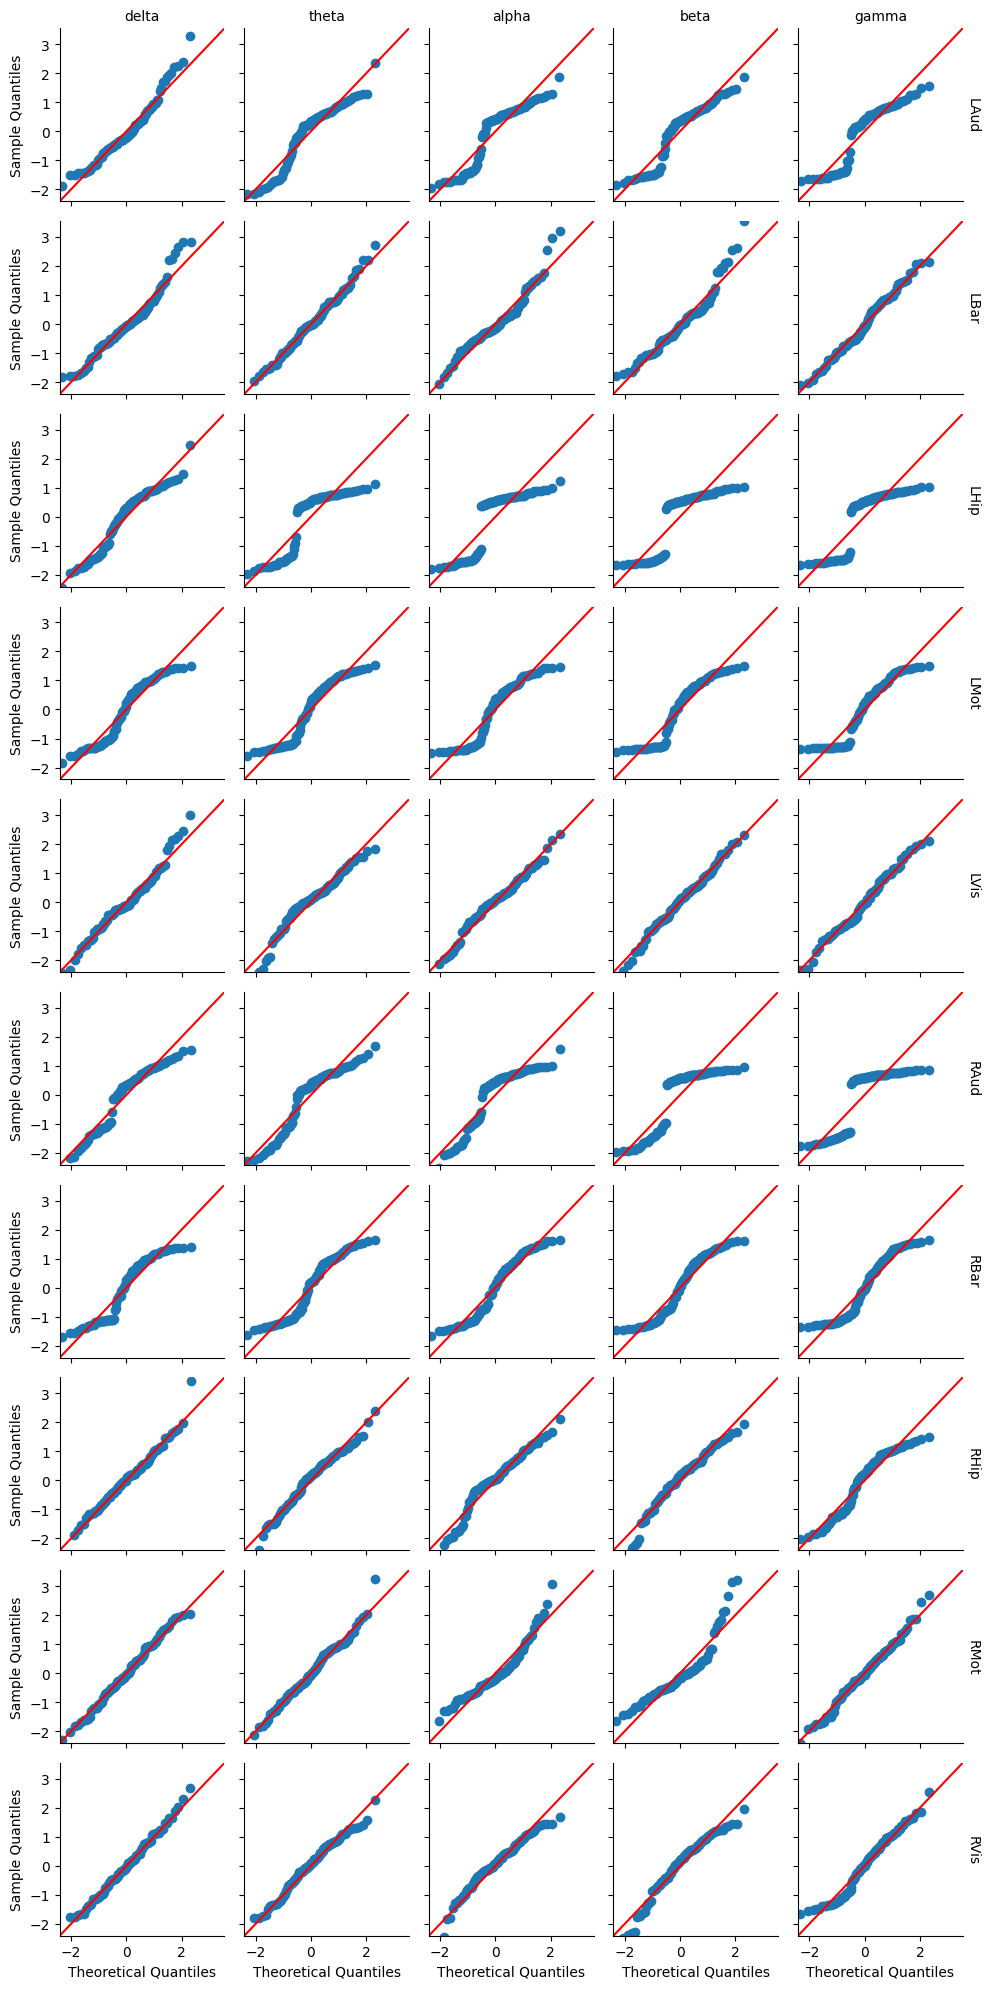

In [22]:
g = ep.plot_qqplot('psdband', ['animal'], row='channel', col='band', height=2, log=True)
plt.show()
# g = ep.plot_qqplot('psdband', ['animal'], row='animal', col='channel', height=3, log=True)
# plt.show()

## Test SAR/MNE

In [23]:
logger.setLevel(logging.DEBUG)

In [24]:
for e in sars:
    e.convert_to_mne(chunk_len=1440)
    # e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

In [25]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-sars/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-sars/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-04-08 15:00:44,850 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-04-08 15:00:44,852 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


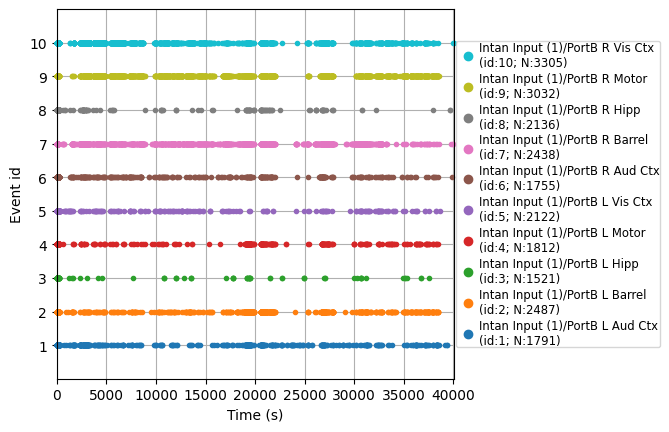

In [ ]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)